In [1]:
# Feature selection
from sklearn.ensemble import RandomForestClassifier as RFC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('classifier_features_subset2.csv')

In [2]:
y_genre, idx_genre = pd.factorize(df['genre'])
df['genre'] = y_genre

In [3]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .66
train, test = df[df['is_train']==True], df[df['is_train']==False]
features = df.columns[2:len(df.columns.values)-2]
forest = RFC(n_estimators=50)

In [5]:
Y = train['genre']
forest.fit(train[features], Y)
y_pred = forest.predict(test[features])
print pd.crosstab(index=test['genre'], columns=y_pred, rownames=['actual'], colnames=['preds'])

preds   0   1   2   4   5   6   8   9   12
actual                                    
0        0   1   1   0   0   2   0   0   0
1        0   5   7   0   1   3   0   3   1
2        0   0  32   0   7   0   2   0   0
3        0   1   5   0   4   0   0   0   0
4        0   0   5   1   1   2   0   2   0
5        0   1   9   0   6   2   0   0   0
6        0   3   4   1   5   2   2   1   0
7        0   1   5   0   2   0   0   1   0
8        0   0   2   0   1   0   3   0   0
9        0   2   5   0   2   0   0  14   0
10       0   3   7   0   2   0   0   1   1
11       0   0   1   0   0   0   0   0   0
12       0   3   1   0   1   0   0   1   0
14       0   0   2   0   0   0   0   0   0
15       3   0   1   0   0   0   0   0   0
16       0   0   1   0   0   0   0   2   0
17       0   0   2   0   0   0   0   0   0
18       0   0   5   0   1   0   0   1   0
19       0   0   2   0   0   1   0   0   0
20       0   0   1   0   1   0   0   0   0
21       0   0   0   0   0   1   0   0   0


In [6]:
importances = forest.feature_importances_
indices = np.argsort(importances)

#plt.figure(1)
#plt.title('Feature Importances')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), features[indices])
#plt.xlabel('Relative Importance')

In [7]:
# selecting the top 5 features
best_features = df.columns[indices[-25:]]

In [8]:
# K-NN Classifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from tabulate import tabulate

X = df[best_features].values
Y = df['genre'].values.T
# creating odd list of K for KNN
myList = list(range(1,10))
# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# 5-Fold Cross Validation
kfold_5 = KFold(n_splits=5, shuffle=False)
kfold_4 = KFold(n_splits=4, shuffle=False)

# out loop of 5 fold cross validation

knn_mse = []
knn_accuracy = []

# 5 - Fold Cross Validation for Test Error Estimation / 4 - Fold Cross Validation for Model Selection"

print "Algorithm = K-Nearest Neighbors"
outerFold = 1
knn_accuracy_scores = []
knn_errors = []
knn_validation_accuracy_scores = []
for train_index, test_index in kfold_5.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # validation scores
    avg_accuracy_scores = []
    metric = dict()
    accuracy_table = dict()
    for k in neighbors:
        metric[k] = dict()
        scores = []
        fold = 1
        for learning_index, validation_index in kfold_4.split(X_train):
            X_learning, X_validation = X_train[learning_index], X_train[validation_index]
            Y_learning, Y_validation = Y_train[learning_index], Y_train[validation_index]
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_learning, Y_learning)
            predicted = knn.predict(X_validation)
            cm = confusion_matrix(Y_validation, predicted)
            accuracy = accuracy_score(Y_validation, predicted)
            scores.append(accuracy)
            metric[k][fold] = cm
            fold += 1
        
        pdAccuracy = pd.DataFrame({'A': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], 'B': scores})
        accuracy_table[k] = pdAccuracy
        avg_accuracy = np.mean(scores)
        avg_accuracy_scores.append(avg_accuracy)
    
    # find optimal K
    MSE = [1 - x for x in avg_accuracy_scores]
    minIdx = np.argmin(MSE)
    optimalK = neighbors[minIdx]
    print '****************************************************************************************'
    print '**********************************  Outer Fold %d   *************************************' %(outerFold)
    print '****************************************************************************************'
    print "Optimal K = " + str(optimalK)
    print '============================================================='
    print 'Training Phase Output'
    print '============================================================='
    print "Accuracy Table for Inner 4-Fold Cross Validation"
    print tabulate(accuracy_table[optimalK], headers=['Fold #','Accuracy'], tablefmt='psql')
    knn_validation_accuracy_scores.append(accuracy_table[optimalK]['B'])
    print '--------------------------------------------------------------'
    print 'Confusion Matrices using Validation data for each inner 4-Fold'
    print '--------------------------------------------------------------'
    for i in range(1,5):
        print ' Inner Fold %d' %(i)
        cm = metric[optimalK][i]
        print cm
        if i<4:
            print '--------------------------------------------------------------'
    print '============================================================='
    print 'Testing Phase Output'
    print '============================================================='
    knn = KNeighborsClassifier(n_neighbors=optimalK)
    knn.fit(X_train, Y_train)
    predicted = knn.predict(X_test)
    cm = confusion_matrix(Y_test, predicted)
    print "Confusion Matrix using Test Data of Outer 5-Fold Cross Val"
    print cm
    accuracy = accuracy_score(Y_test, predicted)
    print "Accuracy = %f" %(accuracy)
    knn_accuracy_scores.append(accuracy)
    knn_errors.append(1-accuracy)
    outerFold += 1
print '--------------------------------------------------------------'
knn_mean_error = np.mean(knn_errors)
print "Mean Error for K-NN Classification %f" %(knn_mean_error)
print '--------------------------------------------------------------'

Algorithm = K-Nearest Neighbors
****************************************************************************************
**********************************  Outer Fold 1   *************************************
****************************************************************************************
Optimal K = 9
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.19697  |
|  1 | Fold 2   |   0.113636 |
|  2 | Fold 3   |   0.160305 |
|  3 | Fold 4   |   0.183206 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 0  0  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  6  0  0  3  0  1  0  3  0  0  0  0  0  0  0  0]
 [ 0  2 19  0  0  1  1  1  0  3  1  0  0  0  0  0  

****************************************************************************************
**********************************  Outer Fold 4   *************************************
****************************************************************************************
Optimal K = 7
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.19697  |
|  1 | Fold 2   |   0.159091 |
|  2 | Fold 3   |   0.136364 |
|  3 | Fold 4   |   0.19084  |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 0  2  3  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 2  1  5  0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2 17  0  0  5  3  0  0  2  0  0  0  0  0  0  0  0  2]
 [ 0  0  2  0  0 

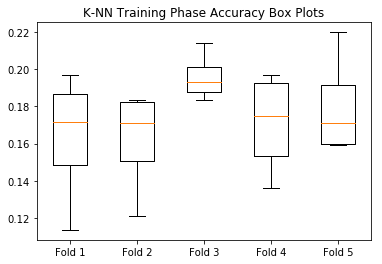

In [9]:
plt.figure(0);
fig, axes = plt.subplots();
axes.boxplot(knn_validation_accuracy_scores, labels=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']);
axes.set_title('K-NN Training Phase Accuracy Box Plots');

In [10]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

def getStrategy(k):
    if k==0 or k==2:
        return "best"
    else:
        return "random"

def getCriterion(k):
    if k==0 or k==1:
        return "gini"
    else:
        return "entropy"

print "Algorithm = Decision Tree"
outerFold = 1
dt_accuracy_scores = []
dt_errors = []
dt_validation_accuracy_scores = []
for train_index, test_index in kfold_5.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # validation scores
    avg_accuracy_scores = []
    metric = dict()
    accuracy_table = dict()
    for k in range(0,4):
        metric[k] = dict()
        scores = []
        fold = 1
        for learning_index, validation_index in kfold_4.split(X_train):
            X_learning, X_validation = X_train[learning_index], X_train[validation_index]
            Y_learning, Y_validation = Y_train[learning_index], Y_train[validation_index]
            criterion = getCriterion(k)
            strategy = getStrategy(k)
            
            dt = DecisionTreeClassifier(criterion=criterion, splitter=strategy)
            dt.fit(X_learning, Y_learning)
            predicted = dt.predict(X_validation)
            cm = confusion_matrix(Y_validation, predicted)
            accuracy = accuracy_score(Y_validation, predicted)
            scores.append(accuracy)
            metric[k][fold] = cm
            fold += 1
        
        pdAccuracy = pd.DataFrame({'A': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], 'B': scores})
        accuracy_table[k] = pdAccuracy
        avg_accuracy = np.mean(scores)
        avg_accuracy_scores.append(avg_accuracy)
    
    # find optimal K
    MSE = [1 - x for x in avg_accuracy_scores]
    optimalK = np.argmin(MSE)
    optimalCriterion = getCriterion(optimalK)
    optimalStrategy = getStrategy(optimalK)
    print '****************************************************************************************'
    print '**********************************  Outer Fold %d   *************************************' %(outerFold)
    print '****************************************************************************************'
    print "Optimal Strategy = " + str(optimalStrategy)
    print "Optimal Criterion = " + str(optimalCriterion)
    print '============================================================='
    print 'Training Phase Output'
    print '============================================================='
    print "Accuracy Table for Inner 4-Fold Cross Validation"
    print tabulate(accuracy_table[optimalK], headers=['Fold #','Accuracy'], tablefmt='psql')
    dt_validation_accuracy_scores.append(accuracy_table[optimalK]['B'])
    print '--------------------------------------------------------------'
    print 'Confusion Matrices using Validation data for each inner 4-Fold'
    print '--------------------------------------------------------------'
    for i in range(1,5):
        print ' Inner Fold %d' %(i)
        cm = metric[optimalK][i]
        #pdCM = pd.DataFrame({'A': ['True', 'False'], 'B': cm[:,0], 'C': cm[:,1]})
        #print tabulate(pdCM, headers=['','True', 'False'], tablefmt='psql')
        print cm
        if i<4:
            print '--------------------------------------------------------------'
    print '============================================================='
    print 'Testing Phase Output'
    print '============================================================='
    dt = DecisionTreeClassifier(criterion=optimalCriterion,splitter=optimalStrategy)
    dt.fit(X_train, Y_train)
    predicted = dt.predict(X_test)
    cm = confusion_matrix(Y_test, predicted)
    print "Confusion Matrix using Test Data of Outer 5-Fold Cross Val"
    print cm
    accuracy = accuracy_score(Y_test, predicted)
    print "Accuracy = %f" %(accuracy)
    dt_accuracy_scores.append(accuracy)
    dt_errors.append(1-accuracy)
    outerFold += 1
print '--------------------------------------------------------------'
mean_error = np.mean(dt_errors)
print "Mean Error for Decision Tree Classification %f" %(mean_error)
print '--------------------------------------------------------------'

Algorithm = Decision Tree
****************************************************************************************
**********************************  Outer Fold 1   *************************************
****************************************************************************************
Optimal Strategy = best
Optimal Criterion = entropy
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.19697  |
|  1 | Fold 2   |   0.174242 |
|  2 | Fold 3   |   0.229008 |
|  3 | Fold 4   |   0.251908 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 0  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  3  0  0  3  1  1  0  1  1  0  0  0  0  0  1  1  0  0]
 [ 1  1

Confusion Matrix using Test Data of Outer 5-Fold Cross Val
[[ 1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  1  2  4  0  1  1  0  1  0  0  0  0  0  1  2  0  0  0]
 [ 0  4 12  0  0  4  1  1  1  0  0  2  1  1  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  2  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  1  3  1  1  4  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  1  1  0  0  1  0  0  0  0  1  1  0  0  1  0  1  1  1  1  0]
 [ 0  0  2  0  0  1  0  1  1  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  1  0  0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  1  0  1  3  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  1  1  2  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  1  0  0  0  0  2  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0 

****************************************************************************************
**********************************  Outer Fold 4   *************************************
****************************************************************************************
Optimal Strategy = best
Optimal Criterion = entropy
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.174242 |
|  1 | Fold 2   |   0.19697  |
|  2 | Fold 3   |   0.159091 |
|  3 | Fold 4   |   0.198473 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 1 1 0 2 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 3 7 1 4 5 3 0 0 2 0 0 2 0 1 0 1 0 2 0 1]
 [0 0 1 1 0 0 0 0 0 0 0 

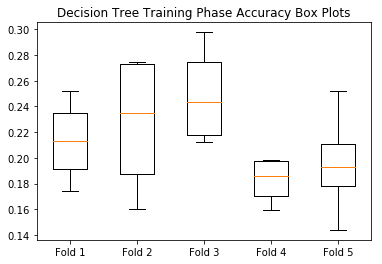

In [11]:
plt.figure(1);
fig, axes = plt.subplots();
axes.boxplot(dt_validation_accuracy_scores, labels=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']);
axes.set_title('Decision Tree Training Phase Accuracy Box Plots');

In [12]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

def getParameters(k):
    if k%3==0:
        maxFeatures = "auto"
    elif k%3==1:
        maxFeatures = "log2"
    else:
        maxFeatures = None
    
    if (k/3)%2==0:
        criterion = "gini"
    else:
        criterion = "entropy"
    
    estimators = ((k/6)+1)*50
    return maxFeatures, criterion, estimators

print "Algorithm = Random Forest"
outerFold = 1
rf_accuracy_scores = []
rf_errors = []
rf_validation_accuracy_scores = []
for train_index, test_index in kfold_5.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # validation scores
    avg_accuracy_scores = []
    metric = dict()
    accuracy_table = dict()
    for k in range(0,24):
        metric[k] = dict()
        scores = []
        fold = 1
        for learning_index, validation_index in kfold_4.split(X_train):
            X_learning, X_validation = X_train[learning_index], X_train[validation_index]
            Y_learning, Y_validation = Y_train[learning_index], Y_train[validation_index]
            maxFeatures, criterion, estimators = getParameters(k)
            rf = RandomForestClassifier(n_estimators=estimators, criterion=criterion, max_features=maxFeatures)
            rf.fit(X_learning, Y_learning)
            predicted = rf.predict(X_validation)
            cm = confusion_matrix(Y_validation, predicted)
            accuracy = accuracy_score(Y_validation, predicted)
            scores.append(accuracy)
            metric[k][fold] = cm
            fold += 1
        
        pdAccuracy = pd.DataFrame({'A': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], 'B': scores})
        accuracy_table[k] = pdAccuracy
        avg_accuracy = np.mean(scores)
        avg_accuracy_scores.append(avg_accuracy)
    
    # find optimal K
    MSE = [1 - x for x in avg_accuracy_scores]
    optimalK = np.argmin(MSE)
    optimalMaxFeatures, optimalCriterion, optimalEstimators = getParameters(k)
    print '****************************************************************************************'
    print '**********************************  Outer Fold %d   *************************************' %(outerFold)
    print '****************************************************************************************'
    print "Optimal Max Features = " + str(optimalMaxFeatures)
    print "Optimal Criterion = " + str(optimalCriterion)
    print "Optimal No. of Estimators = " + str(optimalEstimators)
    print '============================================================='
    print 'Training Phase Output'
    print '============================================================='
    print "Accuracy Table for Inner 4-Fold Cross Validation"
    print tabulate(accuracy_table[optimalK], headers=['Fold #','Accuracy'], tablefmt='psql')
    rf_validation_accuracy_scores.append(accuracy_table[optimalK]['B'])
    print '--------------------------------------------------------------'
    print 'Confusion Matrices using Validation data for each inner 4-Fold'
    print '--------------------------------------------------------------'
    for i in range(1,5):
        print ' Inner Fold %d' %(i)
        cm = metric[optimalK][i]
        print cm
        if i<4:
            print '--------------------------------------------------------------'
    print '============================================================='
    print 'Testing Phase Output'
    print '============================================================='
    rf = RandomForestClassifier(n_estimators=optimalEstimators, criterion=optimalCriterion, max_features=optimalMaxFeatures)
    rf.fit(X_train, Y_train)
    predicted = rf.predict(X_test)
    cm = confusion_matrix(Y_test, predicted)
    print "Confusion Matrix using Test Data of Outer 5-Fold Cross Val"
    print cm
    accuracy = accuracy_score(Y_test, predicted)
    print "Accuracy = %f" %(accuracy)
    rf_accuracy_scores.append(accuracy)
    rf_errors.append(1-accuracy)
    outerFold += 1
print '--------------------------------------------------------------'
mean_error = np.mean(rf_errors)
print "Mean Error for Random Forest Classification %f" %(mean_error)
print '--------------------------------------------------------------'

Algorithm = Random Forest
****************************************************************************************
**********************************  Outer Fold 1   *************************************
****************************************************************************************
Optimal Max Features = None
Optimal Criterion = entropy
Optimal No. of Estimators = 200
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.287879 |
|  1 | Fold 2   |   0.295455 |
|  2 | Fold 3   |   0.40458  |
|  3 | Fold 4   |   0.358779 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  3  0  0  2  5  0  0  2  1  0  0

 Inner Fold 3
[[ 0  2  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  1  0  0  0  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 27  0  0  3  1  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  4  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  1  0  0  4  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  1  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  3  0  0  0  1  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  2  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 

Confusion Matrix using Test Data of Outer 5-Fold Cross Val
[[ 0  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  4  0  1  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3 13  0  0  1  2  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  2  4  0  0  6  2  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  6  0  0  2  0  0  0  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  1  2  0  0  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

****************************************************************************************
**********************************  Outer Fold 5   *************************************
****************************************************************************************
Optimal Max Features = None
Optimal Criterion = entropy
Optimal No. of Estimators = 200
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.348485 |
|  1 | Fold 2   |   0.310606 |
|  2 | Fold 3   |   0.287879 |
|  3 | Fold 4   |   0.412214 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 0  2  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  1  1  0  1  1  0  1  1  0  0  0  0  0  0  1  0  0  

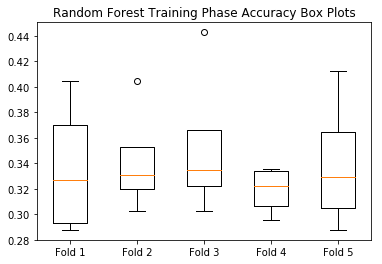

In [13]:
plt.figure(2);
fig, axes = plt.subplots();
axes.boxplot(rf_validation_accuracy_scores, labels=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']);
axes.set_title('Random Forest Training Phase Accuracy Box Plots');

In [14]:
# AdaBoost Classifier

from sklearn.ensemble import AdaBoostClassifier

def getParameters(k):
    if k%2==0:
        algorithm = "SAMME"
    else:
        algorithm = "SAMME.R"
    
    estimators = ((k/2)+1)*50
    return algorithm, estimators

print "Algorithm = Ada Boost"
outerFold = 1
ab_accuracy_scores = []
ab_errors = []
ab_validation_accuracy_scores = []
for train_index, test_index in kfold_5.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # validation scores
    avg_accuracy_scores = []
    metric = dict()
    accuracy_table = dict()
    for k in range(0,8):
        metric[k] = dict()
        scores = []
        fold = 1
        for learning_index, validation_index in kfold_4.split(X_train):
            X_learning, X_validation = X_train[learning_index], X_train[validation_index]
            Y_learning, Y_validation = Y_train[learning_index], Y_train[validation_index]
            algorithm, estimators = getParameters(k)
            ab = AdaBoostClassifier(n_estimators=estimators, algorithm=algorithm)
            ab.fit(X_learning, Y_learning)
            predicted = ab.predict(X_validation)
            cm = confusion_matrix(Y_validation, predicted)
            accuracy = accuracy_score(Y_validation, predicted)
            scores.append(accuracy)
            metric[k][fold] = cm
            fold += 1
        
        pdAccuracy = pd.DataFrame({'A': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], 'B': scores})
        accuracy_table[k] = pdAccuracy
        avg_accuracy = np.mean(scores)
        avg_accuracy_scores.append(avg_accuracy)
    
    # find optimal K
    MSE = [1 - x for x in avg_accuracy_scores]
    optimalK = np.argmin(MSE)
    optimalAlgorithm, optimalEstimators = getParameters(k)
    print '****************************************************************************************'
    print '**********************************  Outer Fold %d   *************************************' %(outerFold)
    print '****************************************************************************************'
    print "Optimal Algorithm = " + str(optimalAlgorithm)
    print "Optimal No. of Estimators = " + str(optimalEstimators)
    print '============================================================='
    print 'Training Phase Output'
    print '============================================================='
    print "Accuracy Table for Inner 4-Fold Cross Validation"
    print tabulate(accuracy_table[optimalK], headers=['Fold #','Accuracy'], tablefmt='psql')
    ab_validation_accuracy_scores.append(accuracy_table[optimalK]['B'])
    print '--------------------------------------------------------------'
    print 'Confusion Matrices using Validation data for each inner 4-Fold'
    print '--------------------------------------------------------------'
    for i in range(1,5):
        print ' Inner Fold %d' %(i)
        cm = metric[optimalK][i]
        print cm
        if i<4:
            print '--------------------------------------------------------------'
    print '============================================================='
    print 'Testing Phase Output'
    print '============================================================='
    ab = AdaBoostClassifier(n_estimators=optimalEstimators, algorithm=optimalAlgorithm)
    ab.fit(X_train, Y_train)
    predicted = ab.predict(X_test)
    cm = confusion_matrix(Y_test, predicted)
    print "Confusion Matrix using Test Data of Outer 5-Fold Cross Val"
    print cm
    accuracy = accuracy_score(Y_test, predicted)
    print "Accuracy = %f" %(accuracy)
    ab_accuracy_scores.append(accuracy)
    ab_errors.append(1-accuracy)
    outerFold += 1
print '--------------------------------------------------------------'
mean_error = np.mean(rf_errors)
print "Mean Error for Ada Boost Classification %f" %(mean_error)
print '--------------------------------------------------------------'

Algorithm = Ada Boost
****************************************************************************************
**********************************  Outer Fold 1   *************************************
****************************************************************************************
Optimal Algorithm = SAMME.R
Optimal No. of Estimators = 200
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.242424 |
|  1 | Fold 2   |   0.242424 |
|  2 | Fold 3   |   0.29771  |
|  3 | Fold 4   |   0.274809 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  8  0  0  3  2  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  

Confusion Matrix using Test Data of Outer 5-Fold Cross Val
[[ 0  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  3  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0 

****************************************************************************************
**********************************  Outer Fold 4   *************************************
****************************************************************************************
Optimal Algorithm = SAMME.R
Optimal No. of Estimators = 200
Training Phase Output
Accuracy Table for Inner 4-Fold Cross Validation
+----+----------+------------+
|    | Fold #   |   Accuracy |
|----+----------+------------|
|  0 | Fold 1   |   0.295455 |
|  1 | Fold 2   |   0.25     |
|  2 | Fold 3   |   0.287879 |
|  3 | Fold 4   |   0.244275 |
+----+----------+------------+
--------------------------------------------------------------
Confusion Matrices using Validation data for each inner 4-Fold
--------------------------------------------------------------
 Inner Fold 1
[[ 0  3  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  1  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 16  0  0  7  0  0

Confusion Matrix using Test Data of Outer 5-Fold Cross Val
[[ 0  0  5  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  1  0  0  0 

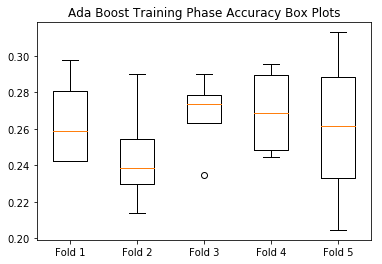

In [15]:
plt.figure(3);
fig, axes = plt.subplots();
axes.boxplot(ab_validation_accuracy_scores, labels=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']);
axes.set_title('Ada Boost Training Phase Accuracy Box Plots');

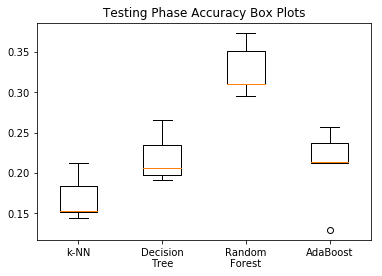

In [16]:
# Comparison of performance of the 5 algorithms

plt.figure(5);
fig, axes = plt.subplots();
dataset = [knn_accuracy_scores,dt_accuracy_scores,rf_accuracy_scores,ab_accuracy_scores]
axes.boxplot(dataset, labels=['k-NN', 'Decision\nTree', 'Random\nForest', 'AdaBoost']);
axes.set_title('Testing Phase Accuracy Box Plots');